# LAB2: END-TO-END MACHINE LEARNING PROJECT

## “FACE DETECTION APPLICATION”

Réalisé par : Nesrine Rouis & Rihab Mribah    3 DNI 1

# **1. Feature Engineering**

In [7]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images

**Q1 – How many positives samples are in positive_patches?**

In [8]:
print(positive_patches.shape)

(13233, 62, 47)


**Q2 – Show some positive samples (e.g., 16) (plt.subplot() and plt.imhsow())**

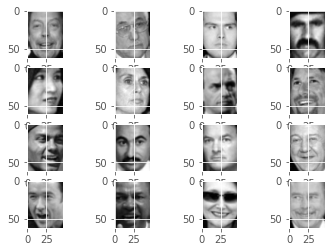

In [9]:
import matplotlib.pyplot as plt
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(positive_patches[i,:,:], cmap='gray')

**Q3 – Try the Scikit-Image’s HOG extractor and visualize the oriented gradients for a given sample:**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  after removing the cwd from sys.path.


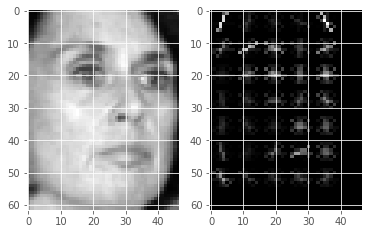

In [10]:
from skimage import color, feature
import skimage.data
sample=positive_patches[5,:,:]
img = color.rgb2gray(sample) #choose a sample here!
hog_vec, hog_vis = feature.hog(img, visualize=True)
dim= hog_vec.shape[0]
plt.subplot(1,2,1)
plt.imshow(sample, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(hog_vis, cmap='gray')

To obtain a set of **negative samples**, we take any corpus of input images from Scikit-Image, and extract patches from them at a variety of scales as follows:

In [11]:
import numpy as np
from skimage import data, transform
from sklearn.feature_extraction.image import PatchExtractor
imgs_to_use = ['camera', 'text', 'coins', 'moon', 'page', 'clock', 'immunohistochemistry', 'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)()) for name in imgs_to_use]
def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
 extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
 extractor = PatchExtractor(patch_size=extracted_patch_size,
 max_patches=N, random_state=0)
 patches = extractor.transform(img[np.newaxis])
 if scale != 1: 
    patches = np.array([transform.resize(patch, patch_size)for patch in patches])
 return patches
negative_patches = np.vstack([extract_patches(im, 1000, scale)
 for im in images for scale in [0.5, 1.0, 2.0]])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  """


**Q4 – How many negative samples are in negative_patches?**

In [12]:
print(negative_patches.shape)

(30000, 62, 47)


**Q5 – Show some negative samples (e.g., 16) (plt.subplot() and plt.imhsow())**

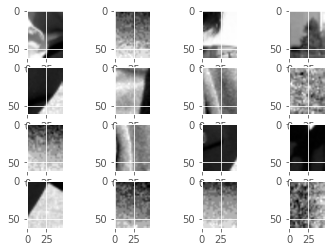

In [13]:
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(negative_patches[i,:,:], cmap='gray')

**Q6 – Combine negative and positive sets (same number of samples in each set) and extract their HOG features to get data set X of size [n_samples, n_features].**


**Q7 – Construct vector of labels y: 0 for all negative samples and 1 for all positive samples.**

In [14]:
N = min(positive_patches.shape[0],negative_patches.shape[0])
X=np.zeros((2*N,dim)) #data
Y=np.concatenate((np.ones((N,1)),np.zeros((N,1))), axis=0) #labels

for i in range(N):
  img=positive_patches[i,:,:]
  img_gray=color.rgb2gray(img)
  hog_vec= feature.hog(img_gray)
  X[i,:]= hog_vec.reshape((1,dim))

#negative
for i in range(N):
  img=negative_patches[i,:,:]
  img_gray=color.rgb2gray(img)
  hog_vec= feature.hog(img_gray)
  X[i+N,:]= hog_vec.reshape((1,dim))
 
print(X.shape)
print(Y.shape)
 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  


(26466, 1215)
(26466, 1)


# **2. Binary Classification using Scikit-Learn**




In [15]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
# View the shape of the data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21172, 1215), (5294, 1215), (21172, 1), (5294, 1))

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

models = [
 { "estimater": KNeighborsClassifier(),
 "params": {
 "n_neighbors": [5],
 "weights": ['uniform'],#,'distance'],
 "leaf_size": [25],
 "p": [1],#,2,3],
 }
 },
 { "estimater": DecisionTreeClassifier(),
 "params": {
 "criterion": ['gini'],#,'entropy'],
 "splitter": ['best'],#,'random'],
 "max_depth": [None],#,90,95,100],
 "max_features": [None],#, "auto","sqrt","log2"],
 "random_state": [42]
 }
 },
 
 { "estimater": svm.SVC(),
 "params": {
'C': [0.1], 'gamma': [1], 'kernel': ['rbf']
 }
 },
 { "estimater": RandomForestClassifier(),
 "params": {
 "criterion": ['gini'],#,'entropy'],
 "bootstrap": [True],#, False],
 "max_depth": [85],#90,95,100],
 "max_features": ['sqrt'],#,'log2'],
 "n_estimators": [60],# 80, 90],
 "random_state": [42]
 }
 }
]
column_names = ["KNeighbors", "DecisionTree", "SVM", "RF"]
entries = []
max_acc = 0
best_model = None
for model in models:
 print(model["estimater"])
 # Create model
 clf = model["estimater"]
 # Instantiate the grid search model
 grid_search = GridSearchCV(estimator = clf, param_grid = model["params"],
 cv = 5)
 
 # Fit the model
 grid_search.fit(X_train, y_train);
 # Make predictions on the test set compute accuracy metric
 predicted = grid_search.predict(X_test)
 acc = accuracy_score(predicted, y_test)
 entries.append(acc)
 print(grid_search.best_params_)
 # Get the best model with the highest accuracy
 if acc > max_acc:
    max_acc = acc
 best_model = grid_search


KNeighborsClassifier()


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

{'leaf_size': 25, 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
DecisionTreeClassifier()
{'criterion': 'gini', 'max_depth': None, 'max_features': None, 'random_state': 42, 'splitter': 'best'}
SVC()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
RandomForestClassifier()


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

{'bootstrap': True, 'criterion': 'gini', 'max_depth': 85, 'max_features': 'sqrt', 'n_estimators': 60, 'random_state': 42}


Now, we plot each model performance:


      Estimator  Accuracy
0    KNeighbors  0.997922
1  DecisionTree  0.936154
2           SVM  0.533245
3            RF  0.989611


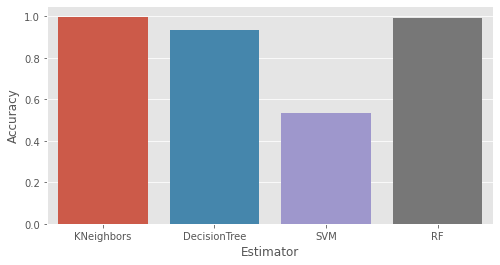

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('ggplot')
df = pd.DataFrame({"Estimator": column_names, "Accuracy": entries})
plt.figure(figsize=(8, 4))
sns.barplot(x='Estimator', y='Accuracy', data=df)
print(df)


# **3. Evaluating the Best Face Detector**

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def evaluate_preds(y_true, y_preds):
 """
 Performs evaluation comparison on y_true labels vs. y_pred labels
 on a classification.
 """
 accuracy = accuracy_score(y_true, y_preds)
 precision = precision_score(y_true, y_preds, average='micro')
 recall = recall_score(y_true, y_preds, average='micro')
 f1 = f1_score(y_true, y_preds, average='micro')
 metric_dict = {"accuracy": round(accuracy, 2),
 "precision": round(precision, 2),
 "recall": round(recall, 2),
 "f1": round(f1, 2)}
 
 return metric_dict


**Q9 – Make predictions using the test data to see how the best model performs by applying the 
evaluate_preds function.**

In [19]:
y_preds = best_model.predict(X_test)
dict_pred= evaluate_preds(y_test, y_preds)
print(dict_pred)

{'accuracy': 0.99, 'precision': 0.99, 'recall': 0.99, 'f1': 0.99}


# **4. Finding Faces in a New Image**


**Q10 - Get a new test image by executing this script:**

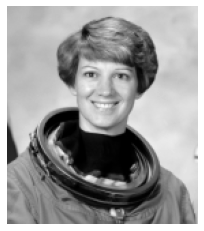

In [20]:
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]
plt.imshow(test_image, cmap='gray')
plt.axis('off');


**Q11 - Create a window that iterates over patches of this image, and compute HOG features for 
each patch:**

In [28]:
def sliding_window(img, patch_size=positive_patches[0].shape,istep=2, jstep=2, scale=1.0):
 Ni, Nj = (int(scale * s) for s in patch_size)
 for i in range(0, img.shape[0] - Ni, istep):
  for j in range(0, img.shape[1] - Ni, jstep):
    patch = img[i:i + Ni, j:j + Nj]
    if scale != 1:
      patch = transform.resize(patch, patch_size)
    yield (i, j), patch
 
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])


**Q12 - Use our face detector to evaluate whether each patch contains a face. What do you notice?**

In [30]:
labels = best_model.predict(patches_hog)
labels.sum()


68.0

**Q13 - Draw face detected patches as rectangles:**

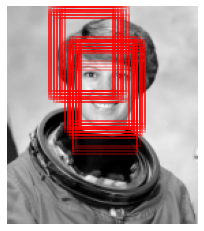

In [31]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')
Ni, Nj = positive_patches[0].shape
indices = np.array(indices)
for i, j in indices[labels == 1]:
 ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
 alpha=0.3, lw=2, facecolor='none'))

# **5. Model Deployment with Python and Streamlit**


 **Saving our model:**


In [34]:
import joblib
# save the model to disk
joblib.dump(best_model, "Nesrine&Rihab.sav")

['Nesrine&Rihab.sav']